In [1]:
import numpy as np
import random as rm
import pandas as pd
from random import seed
from random import random
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from scipy.stats import bernoulli, binom, norm
from scipy import integrate

### generalized toy example Self-Interacting

In [2]:
# generalized toy example
def simulate(mu_list, sigma_list, n, alpha_list, p, y0, sigma, x0, epsilon):
    def f_pi(x):
        val = 0
        for i in range(len(mu_list)):
            val += alpha_list[i]*norm.pdf(x,mu_list[i], sigma_list[i]**0.5)
        '''
        val = [sum(alpha_list[i]*norm.pdf(x,mu_list[i], sigma_list[i]**0.5)) for i in range(len(mu_list))]
        '''
        return val

    def pdf_eta(x):
        return f_pi(x)**p

    c = integrate.quad(pdf_eta, -np.inf, np.inf)[0]
    
    def f_eta(x):
        return pdf_eta(x)/c
    
    def g(x):
        return(f_pi(x)/f_eta(x))
    
    def p_kernel(y0, sigma, n):
        count = 0
        Yn = y0
        estimator = [y0]
        while count<n:
            y = np.random.normal(Yn, sigma)
            u = np.random.uniform(0,1)
            alpha = min((pdf_eta(y)/pdf_eta(Yn)),1)
            if u <= alpha:
                estimator.append(y)
                Yn = y
                count += 1
        return estimator
    
    def k_kernel(x0, sigma):
        count = 0
        Xn = x0
        estimator = [x0]
        while count<1:
            y = np.random.normal(Xn,sigma)
            u = np.random.uniform(0,1)
            alpha = min((pdf_eta(y)/pdf_eta(Xn)),1)
            if u <= alpha:
                estimator.append(y)
                Xn = y
                count += 1
        return estimator[-1]
    
    def sum_g(sum_old, yn):
        return sum_old + g(yn)

    def prob_list(y, sum_new):
        prob_list = [g(i)/sum_new for i in y]
        return prob_list
        '''
        prob_list = []
        for i in y:
            prob_list.append(g(i)/sum_new)
        '''
    
    def bernoulli_list(epsilon, n):
        return bernoulli(epsilon).rvs(n)
        
    
    def x_sample(x0, epsilon, y0, n, sigma):
        X_list = [0]*n
        X_list[0] = x0
        Y_list = [0]*n
        Y_list[0] = y0
        sum_gs = g(y0)
        Y_list = p_kernel(y0,sigma,n)
        for k in range(1, n):
            sum_gs = sum_g(sum_gs, Y_list[k])
            prob_list_Ys = prob_list(Y_list[:k+1], sum_gs)
            i = bernoulli_list(epsilon, 1)
            if i == 0:
                X_list[k] = (k_kernel(x0, sigma))
            if i == 1:
                X_list[k] = (np.random.choice(Y_list[:k+1], p = prob_list_Ys))
            x0 = X_list[k]
        return X_list
    

    
    X_list = x_sample(x0, epsilon, y0, n, sigma)
    mean = sum(X_list)/len(X_list)
    #
    
    return [X_list, mean]

In [6]:
mu_list = [0,17.5,10]
sigma_list = [.5,1,0.7]
alpha_list = [0.4,0.2,0.4]
p = 0.75
n = 300
y0 = 15
x0 = 10
sigma = 10
epsilon = 0.05

X_list = simulate(mu_list, sigma_list, n, alpha_list, p, y0, sigma, x0, epsilon)[0]
# mean = simulate(mu_list, sigma_list, n, alpha_list, p, y0, sigma, x0, epsilon)[1]

In [4]:
print(mean)

10.176755830703545


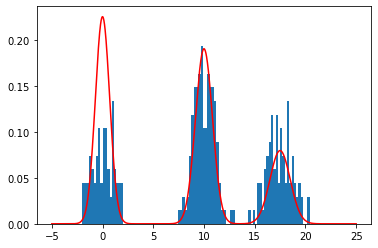

In [7]:
# plot
pdf_pi = lambda x: 0.4*(1/np.sqrt(2*math.pi*0.5))*np.exp((-1/2)*((x-0)**2/0.5)) + 0.2*(1/np.sqrt(2*math.pi*1))*np.exp((-1/2)*((x-17.5)**2/1))+0.4*(1/np.sqrt(2*math.pi*0.7))*np.exp((-1/2)*((x-10)**2/0.7))

plt.hist(X_list, density = True, bins = 100)
t = np.linspace(-5,25,1000)
vals = pdf_pi(t)
plt.plot(t,vals, 'r')

### many particles, $x_i$ with $y_i$ Parallel

In [17]:
# x_i move according to y_i
def simulate_list1(mu_list, sigma_list, n, alpha_list, p, y0_list, sigma, x0_list, epsilon, N):
    def f_pi(x):
        val = 0
        for i in range(len(mu_list)):
            val += alpha_list[i]*norm.pdf(x,mu_list[i], sigma_list[i]**0.5)
        return val

    def pdf_eta(x):
        return f_pi(x)**p

    c = integrate.quad(pdf_eta, -np.inf, np.inf)[0]
    
    def f_eta(x):
        return pdf_eta(x)/c
    
    def g(x):
        return(f_pi(x)/f_eta(x))
    
    '''
    def p_kernel_adjust(y0_list, sigma, n):
        Yn_list = y0_list
        estimator_matrix = np.empty((0,n), int)
        for i in range(len(Yn_list)):
            count = 0
            estimator_list = [y0_list[i]]
            Yn_list = y0_list
            while count<n:
                y = np.random.normal(Yn_list[i], sigma)
                u = np.random.uniform(0,1)
                alpha = (min((pdf_eta(y)/pdf_eta(Yn_list[i])),1))
                if u <= alpha:
                    estimator_list.append(y)
                    Yn_list[i] = y
                    count += 1
            estimator_matrix = np.append(estimator_matrix, [estimator_list[1:]], axis=0)
        return estimator_matrix

    def k_kernel_adjust(x0_list,sigma):
        Xn_list = x0_list
        estimator_matrix = np.empty((0,2), int)
        for i in range(len(Xn_list)):
            count = 0
            estimator_list = [x0_list[i]]
            Xn_list = x0_list
            while count<1:
                y = np.random.normal(Xn_list[i],sigma)
                u = np.random.uniform(0,1)
                alpha = min((pdf_eta(y)/pdf_eta(Xn_list[i])),1)
                if u <= alpha:
                    estimator_list.append(y)
                    Xn_list[i] = y
                    count +=1
            estimator_matrix = np.append(estimator_matrix, [estimator_list], axis=0)
        return estimator_matrix
    '''
    
    def p_kernel(y0, sigma, n):
        count = 0
        Yn = y0
        estimator = [y0]
        while count<n:
            y = np.random.normal(Yn, sigma)
            u = np.random.uniform(0,1)
            alpha = min((pdf_eta(y)/pdf_eta(Yn)),1)
            if u <= alpha:
                estimator.append(y)
                Yn = y
                count += 1
        return estimator
    
    def k_kernel(x0, sigma):
        count = 0
        Xn = x0
        estimator = [x0]
        while count<1:
            y = np.random.normal(Xn,sigma)
            u = np.random.uniform(0,1)
            alpha = min((pdf_eta(y)/pdf_eta(Xn)),1)
            if u <= alpha:
                estimator.append(y)
                Xn = y
                count += 1
        return estimator[-1]
    
    def sum_g(sum_old, yn):
        sum_new = sum_old + g(yn)
        return sum_new

    def prob_list(y, sum_new):
        prob_list = []
        for i in y:
            prob_list.append(g(i)/sum_new)
        return prob_list
    
    def bernoulli_list(epsilon, n):
        b_list = bernoulli(epsilon).rvs(n)
        return b_list
    
    def x_sample(x0_list, epsilon, y0_list, n, sigma, N):
        X_matrix = np.empty((0,n),int)
        Y_matrix = np.empty((0,n),int)
        for i in range(N):
            sum_gs = g(y0_list[i])
            X_list = [x0_list[i]]
            Y_list = p_kernel(y0_list[i], sigma, n)
            for k in range(1, n):
                sum_gs = sum_g(sum_gs, Y_list[k])
                prob_list_Ys = prob_list(Y_list[:k+1], sum_gs)
                j = bernoulli_list(epsilon, 1)
                if j == 0:
                    X_list.append(k_kernel(x0_list[i], sigma))
                if j == 1:
                    X_list.append(np.random.choice(Y_list[:k+1], p = prob_list_Ys))
            X_matrix = np.append(X_matrix, [X_list], axis=0)
            x0_list[i] = X_matrix[i][-1]
        return X_matrix
    
    def E_x(X_matrix):
        sum_matrix = X_matrix.sum()
        len_matrix = X_matrix.size
        average_matrix = sum_matrix/len_matrix
        return average_matrix
    
    X_matrix = x_sample(x0_list, epsilon, y0_list, n, sigma, N)
    mean = E_x(X_matrix)
    
    return [mean, X_matrix.flatten()]

In [18]:
mu_list = [0,17.5,10]
sigma_list = [.5,1,0.7]
alpha_list = [0.4,0.2,0.4]
p = 0.75
n = 200
y0_list = [15, -5, 12, 1, -2]
x0_list = [10, 13, -4, -2, 3]
sigma = 10
epsilon = 0.05
N = 5

X_list = simulate_list1(mu_list, sigma_list, n, alpha_list, p, y0_list, sigma, x0_list, epsilon, N)[1]

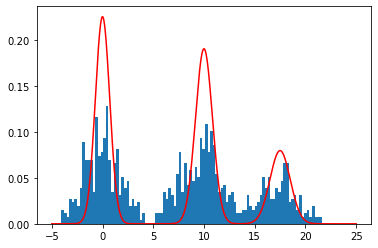

In [19]:
pdf_eta = lambda x: 0.4*(1/np.sqrt(2*math.pi*0.5))*np.exp((-1/2)*((x-0)**2/0.5)) + 0.2*(1/np.sqrt(2*math.pi*1))*np.exp((-1/2)*((x-17.5)**2/1))+0.4*(1/np.sqrt(2*math.pi*0.7))*np.exp((-1/2)*((x-10)**2/0.7))

plt.hist(X_list, density = True, bins = 100)
t = np.linspace(-5,25,1000)
vals = pdf_eta(t)
plt.plot(t,vals, 'r')

### all $ys$ past positions Auxiliary

In [14]:
# x_i move according to all ys
def simulate_list2(mu_list, sigma_list, n, alpha_list, p, y0_list, sigma, x0_list, epsilon, N):
    def f_pi(x):
        val = 0
        for i in range(len(mu_list)):
            val += alpha_list[i]*norm.pdf(x,mu_list[i], sigma_list[i]**0.5)
        return val

    def pdf_eta(x):
        return f_pi(x)**p

    c = integrate.quad(pdf_eta, -np.inf, np.inf)[0]
    
    def f_eta(x):
        return pdf_eta(x)/c
    
    def g(x):
        return(f_pi(x)/f_eta(x))
    
    '''
    def p_kernel_adjust(y0_list, sigma, n):
        Yn_list = y0_list
        estimator_matrix = np.empty((0,n), int)
        for i in range(len(Yn_list)):
            count = 0
            estimator_list = [y0_list[i]]
            Yn_list = y0_list
            while count<n:
                y = np.random.normal(Yn_list[i], sigma)
                u = np.random.uniform(0,1)
                alpha = (min((pdf_eta(y)/pdf_eta(Yn_list[i])),1))
                if u <= alpha:
                    estimator_list.append(y)
                    Yn_list[i] = y
                    count += 1
            estimator_matrix = np.append(estimator_matrix, [estimator_list[1:]], axis=0)
        return estimator_matrix

    def k_kernel_adjust(x0_list,sigma):
        Xn_list = x0_list
        estimator_matrix = np.empty((0,2), int)
        for i in range(len(Xn_list)):
            count = 0
            estimator_list = [x0_list[i]]
            Xn_list = x0_list
            while count<1:
                y = np.random.normal(Xn_list[i],sigma)
                u = np.random.uniform(0,1)
                alpha = min((pdf_eta(y)/pdf_eta(Xn_list[i])),1)
                if u <= alpha:
                    estimator_list.append(y)
                    Xn_list[i] = y
                    count +=1
            estimator_matrix = np.append(estimator_matrix, [estimator_list], axis=0)
        return estimator_matrix
    '''
    
    def p_kernel(y0, sigma, n):
        count = 0
        Yn = y0
        estimator = [y0]
        while count<n:
            y = np.random.normal(Yn, sigma)
            u = np.random.uniform(0,1)
            alpha = min((pdf_eta(y)/pdf_eta(Yn)),1)
            if u <= alpha:
                estimator.append(y)
                Yn = y
                count += 1
        return estimator
    
    def k_kernel(x0, sigma):
        count = 0
        Xn = x0
        estimator = [x0]
        while count<1:
            y = np.random.normal(Xn,sigma)
            u = np.random.uniform(0,1)
            alpha = min((pdf_eta(y)/pdf_eta(Xn)),1)
            if u <= alpha:
                estimator.append(y)
                Xn = y
                count += 1
        return estimator[-1]
    
    def sum_g(sum_old, yn):
        sum_new = sum_old + g(yn)
        return sum_new
    
    def prob_matrix(Y_matrix, sum_new):
        prob_matrix = np.zeros((len(Y_matrix),len(Y_matrix[0])))
        for i in range(len(Y_matrix[0])):
            for j in range(len(Y_matrix)):
                prob_matrix[j][i] = g(Y_matrix[j][i])/sum_new
        return prob_matrix
    
    def bernoulli_list(epsilon, n):
        b_list = bernoulli(epsilon).rvs(n)
        return b_list
    
    def x_sample(x0_list, epsilon, y0_list, n, sigma, N):
        X_matrix = np.zeros((N,n))
        Y_matrix = np.zeros((N,n))
        sum_Gs = 0
        for i in range(n):
            sum_gs = 0
            for j in range(N):
                if i == 0:
                    Y_matrix[j][i] = y0_list[j]
                    sum_gs = sum_g(sum_gs, y0_list[j])
                else:
                    Y_matrix[j][i] = p_kernel(y0_list[j], sigma, 1)[-1]
                    y0_list[j] = Y_matrix[j][i]
                    sum_gs = sum_g(sum_gs, Y_matrix[j][i])
            sum_Gs += sum_gs
            Prob_matrix = prob_matrix(Y_matrix[:,0:i+1], sum_Gs)
            Y_matrix_flatten = Y_matrix[:,0:i+1].flatten()
            Prob_matrix_flatten = Prob_matrix.flatten()
            for j in range(N):
                b = bernoulli_list(epsilon, 1)
                if b == 0:
                    X_matrix[j][i] = k_kernel(x0_list[j], sigma)
                if b == 1:
                    X_matrix[j][i] = np.random.choice(Y_matrix_flatten, p = Prob_matrix_flatten)
                x0_list[j] = X_matrix[j][i]
        return X_matrix
    
    def E_x(X_matrix):
        sum_matrix = X_matrix.sum()
        len_matrix = X_matrix.size
        average_matrix = sum_matrix/len_matrix
        return average_matrix
    
    X_matrix = x_sample(x0_list, epsilon, y0_list, n, sigma, N)
    mean = E_x(X_matrix)
    
    return mean, X_matrix.flatten()

In [15]:
mu_list = [0,17.5,10]
sigma_list = [.5,1,0.7]
alpha_list = [0.4,0.2,0.4]
p = 0.75
n = 100
y0_list = [15, 5, 2, 11, 2]
x0_list = [10,3,14,-2,13]
sigma = 10
epsilon = 0.05
N = 5

X_list = simulate_list2(mu_list, sigma_list, n, alpha_list, p, y0_list, sigma, x0_list, epsilon, N)[1]
mean = simulate_list2(mu_list, sigma_list, n, alpha_list, p, y0_list, sigma, x0_list, epsilon, N)[0]
print(mean)

9.117808817075531


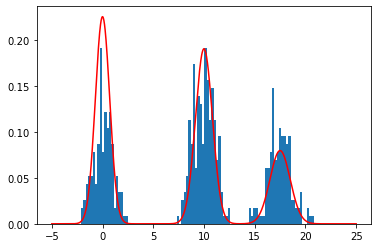

In [16]:
pdf_pi = lambda x: 0.4*(1/np.sqrt(2*math.pi*0.5))*np.exp((-1/2)*((x-0)**2/0.5)) + 0.2*(1/np.sqrt(2*math.pi*1))*np.exp((-1/2)*((x-17.5)**2/1))+0.4*(1/np.sqrt(2*math.pi*0.7))*np.exp((-1/2)*((x-10)**2/0.7))

plt.hist(X_list, density = True, bins = 100)
t = np.linspace(-5,25,1000)
vals = pdf_pi(t)
plt.plot(t,vals, 'r')